# Time_Task

## Обзор данных

Скачаем данные из файла

![image.png](attachment:2dc94094-62ec-4f63-a6c2-4b6d3b13c16b.png)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Чтобы ошибки не мозолили глаза
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
raw_data = pd.read_csv('TimeSer_Zach_for.csv', header = None)

## Функции, необходимые для работы

In [ ]:
# Функции для вывода быстрой информации
def pandas_info(data):
    '''
    список всех данных в пандасе
    '''
    print(*[data.info(), data.describe(), data.shape, data.index], sep="\n-----------------------\n")

    
def series_info(data):
    '''
    список всех данных в пандас сериесе
    '''
    print(*[data.describe(), data.shape, data.index], sep="\n-----------------------\n")

    
def numpy_info(data):
    '''
    список всех данных в нумпае
    '''
    print(np.info(data), '\n--------\n', data[:5], '\n--------\n')

In [ ]:
def create_posix(data, freq):
    data_freq = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq) 
    data_posix = np.array(data_freq.astype(int) // 10 ** 9).reshape(-1,1)
    return data_posix

In [ ]:
# Функция разделения на обуч. и тестовые выборки
def train_test_split_dt(data_posix, data_pd, year):
    
    X_train = data_posix.loc[data_pd.index < year].astype(int)
    X_train = create_posix(X_train, 'D')
#     X_train = np.array(X_train.index).reshape(-1,1)
    
    y_train = data_pd.loc[data_pd.index < year]
    y_train = np.array(y_train).reshape(-1,1)
    
    X_test = data_posix.loc[data_pd.index > year].astype(int)
    X_test = create_posix(X_test, 'D')
#     X_test = np.array(X_test.index).reshape(-1,1)
    
    y_test = data_pd.loc[data_pd.index > year]
    y_test = np.array(y_test).reshape(-1,1)
    
    return X_train, y_train, X_test, y_test

In [ ]:
def few_regressors(X_train, y_train, X_test, y_test):
    forest_data = RandomForestRegressor().fit(X_train, y_train)
    print(str(forest_data), forest_data.score(X_test, y_test))
    
    elastic_net = ElasticNet().fit(X_train, y_train)
    print(str(elastic_net), elastic_net.score(X_test, y_test))
    
    gradient_boost = GradientBoostingRegressor().fit(X_train, y_train)
    print(str(gradient_boost), gradient_boost.score(X_test, y_test))
    
    svr = SVR(kernel='rbf').fit(X_train, y_train)
    print(str(svr), svr.score(X_test, y_test))

    ln = LinearRegression().fit(X_train, y_train)
    print(str(ln), ln.score(X_test, y_test))
   
    fig = plt.subplots(figsize = (20,7))
    
    plt.scatter(X_train, y_train, label='Обуч. данные', color='Blue')
    plt.scatter(X_test, y_test, label='Тест. данные', color='Orange')
    
    plt.plot(X_test, forest_data.predict(X_test), label='Случ. лес', linewidth = 2)
    plt.plot(X_test, elastic_net.predict(X_test), label='Эластич. регр.', linewidth = 2)
    plt.plot(X_test, gradient_boost.predict(X_test), label='Град. буст.', linewidth = 2)
    plt.plot(X_test, svr.predict(X_test), label='Метод опорн. вект.', linewidth = 2)
    plt.plot(X_test, ln.predict(X_test), label='Лин. регр', linewidth = 2)
    
    plt.legend();
    
#     return forest_data, svr, knn, ln, mlp

In [ ]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

In [ ]:
def cross_val(X_train, y_train, X_test, y_test, models_list):
    results, rmse_result, names = [], [], []
    for name, model in models_list:
        mod = model.fit(X_train, y_train)

        tscv = TimeSeriesSplit(n_splits=5)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
        results.append(cv_results)
        rmse_result.append(rmse(y_test, model.predict(X_test)))
        names.append(name)

        print(model, '\nRMSE:', rmse(y_test, model.predict(X_test)))
        print('Mean:', cv_results.mean(), '\nStd:', cv_results.std(), '\n')

    fig = plt.subplots(figsize = (10,7))
    plt.boxplot(results, labels=names)
    plt.title('Сравнение алгоритмов')
    plt.ylabel('Квадрат ошибки R2')
    plt.xlabel('Методы регрессии')
    plt.show()
    
    return names, results, rmse_result

In [ ]:
pandas_info(raw_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8089 entries, 0 to 8088
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       8089 non-null   object
 1   1       8089 non-null   object
 2   2       8089 non-null   object
 3   3       8089 non-null   object
 4   4       8089 non-null   object
 5   5       8089 non-null   object
 6   6       8089 non-null   object
dtypes: object(7)
memory usage: 442.5+ KB
None
-----------------------
                  0             1       2                                 3  \
count          8089          8089    8089                              8089   
unique         2832          4679       7                                15   
top     2015-04-10    "       0"    "en"    "Millennium_Development_Goals"    
freq             13           825    5231                              2831   

             4           5                                6  
count     8089        8089               

*Видно, что:*
- В данных 8089 строк, 7 признаков
- Все признаки объектного типа

*Признаки:*
- <code>date</code>: дата записи
- <code>count</code>: количество запросов
- <code>lang</code>: язык домена
- <code>page</code>: страница на сайте
- <code>rank</code>: рейтинг сайта, всего 8 разных рейтингов
- <code>month</code>: другое представление даты в виде ГГГГММ
- <code>title</code>: заголовок/название страницы, тоже самое, что и <code>page</code>

# Предобработка сырых данных

## Удаление кавычек из данных
В данных есть лишние кавычки <code>""</code>, от них решено избавиться для удобства работы с данными

In [ ]:
raw_data.head(10)

,0,1,2,3,4,5,6
0,date,"""count""","""lang""","""page""","""rank""","""month""","""title"""
1,2015-04-30,"""18102799""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
2,2015-04-08,"""18297719""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
3,2015-04-09,"""18048572""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
4,2015-04-01,"""14418119""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
5,2015-04-02,"""11297180""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
6,2015-04-03,"""13383207""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
7,2015-04-04,"""17081542""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
8,2015-04-05,"""16332148""","""en""","""Main_page""","""2""","""201504""","""Main_page"""
9,2015-04-06,"""19546248""","""en""","""Main_page""","""2""","""201504""","""Main_page"""


In [ ]:
clear_data = raw_data.replace(to_replace ='[" ]', value = '', regex = True)
clear_data = clear_data.rename(columns = clear_data.iloc[0]).drop(clear_data.index[0])
clear_data

,date,count,lang,page,rank,month,title
1,2015-04-30,18102799,en,Main_page,2,201504,Main_page
2,2015-04-08,18297719,en,Main_page,2,201504,Main_page
3,2015-04-09,18048572,en,Main_page,2,201504,Main_page
4,2015-04-01,14418119,en,Main_page,2,201504,Main_page
5,2015-04-02,11297180,en,Main_page,2,201504,Main_page
...,...,...,...,...,...,...,...
8084,2015-09-08,9069,ru,%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%...,-1,201509,Исламское_государство
8085,2015-09-21,8831,ru,%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%...,-1,201509,Исламское_государство
8086,2015-09-20,9913,ru,%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%...,-1,201509,Исламское_государство
8087,2015-09-09,9637,ru,%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%...,-1,201509,Исламское_государство


## Поиск дубликатов

In [ ]:
print(clear_data.duplicated().sum())

0


<div class='alert class-block alert-success'>
    Дубликатов не найдено
</div>

## Удаление столбца <code>page</code>

Столбцы page и title практически ничем не отличаются, кроме того, что в столбце <code>page</code> у киррилицы и арабского алфавита сбит юникод

*Все уникальные значения <code>page</code> и <code>title</code>*

In [ ]:
print(clear_data['page'].unique())
print()
print(clear_data['title'].unique())

['Main_page' 'Millennium_Development_Goals' 'Climate_Change'
 'Objetivos_de_Desarrollo_del_Milenio'
 'Islamic_State_of_Iraq_and_the_Levant' '%D8%AF%D8%A7%D8%B9%D8%B4'
 'Islamischer_Staat_(Organisation)' 'Estado_Isl%C3%A1mico'
 '%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%BE%D0%B5_%D0%B3%D0%BE%D1%81%D1%83%D0%B4%D0%B0%D1%80%D1%81%D1%82%D0%B2%D0%BE_%D0%98%D1%80%D0%B0%D0%BA%D0%B0_%D0%B8_%D0%9B%D0%B5%D0%B2%D0%B0%D0%BD%D1%82%D0%B0'
 'Syria' 'Cheese'
 '%D8%AA%D9%86%D8%B8%D9%8A%D9%85_%D8%A7%D9%84%D8%AF%D9%88%D9%84%D8%A9_%D8%A7%D9%84%D8%A5%D8%B3%D9%84%D8%A7%D9%85%D9%8A%D8%A9_(%D8%AF%D8%A7%D8%B9%D8%B4)'
 'Iraq_kap_Levant_Islam_Kok'
 '%D0%98%D1%81%D0%BB%D0%B0%D0%BC%D1%81%D0%BA%D0%BE%D0%B5_%D0%B3%D0%BE%D1%81%D1%83%D0%B4%D0%B0%D1%80%D1%81%D1%82%D0%B2%D0%BE']

['Main_page' 'Millennium_Development_Goals' 'Climate_Change'
 'Objetivos_de_Desarrollo_del_Milenio'
 'Islamic_State_of_Iraq_and_the_Levant' 'داعش'
 'Islamischer_Staat_(Organisation)' 'Estado_Islámico'
 'Исламское_государство_Ирака_и_Леванта'

Хорошо видно, что все буквы, кроме латинских выглядят в виде %D и т.д.

Таким образом мы можем избавиться от дублирующего признака, а затем переименуем <code>title</code> в <code>page</code>

In [ ]:
clear_data = clear_data.drop(['page'], axis = 1).rename(columns={'title': 'page'})
clear_data.head()

,date,count,lang,rank,month,page
1,2015-04-30,18102799,en,2,201504,Main_page
2,2015-04-08,18297719,en,2,201504,Main_page
3,2015-04-09,18048572,en,2,201504,Main_page
4,2015-04-01,14418119,en,2,201504,Main_page
5,2015-04-02,11297180,en,2,201504,Main_page


## Выбираем только те строки, в которых <code>page = Millennium_Development_Goals</code>

In [ ]:
clear_data_1 = clear_data.loc[clear_data['page'] == 'Millennium_Development_Goals']
clear_data_1

,date,count,lang,rank,month,page
31,2015-04-30,1739,en,7435,201504,Millennium_Development_Goals
32,2015-04-08,1886,en,7435,201504,Millennium_Development_Goals
33,2015-04-09,1838,en,7435,201504,Millennium_Development_Goals
34,2015-04-01,1630,en,7435,201504,Millennium_Development_Goals
35,2015-04-02,1428,en,7435,201504,Millennium_Development_Goals
...,...,...,...,...,...,...
6347,2015-08-19,1044,en,7435,201508,Millennium_Development_Goals
6348,2015-08-18,1005,en,7435,201508,Millennium_Development_Goals
6349,2015-08-27,899,en,7435,201508,Millennium_Development_Goals
6350,2015-08-24,1065,en,7435,201508,Millennium_Development_Goals


<div class='alert class-block alert-info'>
    Были выбраны все строки, соответсвующие условию в подзаголовке, их оказалось 2831 шт.
</div>

## Проверим данные на Nan

In [ ]:
clear_data.isna().sum()

date     0
count    0
lang     0
rank     0
month    0
page     0
dtype: int64

<div class='alert class-block alert-success'>
    Nan не обнаружено
</div>

## Сделаем индексным столбцом дату

In [ ]:
clear_data_datetime = clear_data_1
clear_data_datetime['new_date'] = pd.to_datetime(clear_data['date'], format='%Y-%m-%d')
clear_data_datetime = clear_data_datetime.set_index('new_date').drop(['date'], axis = 1)
clear_data_datetime

,count,lang,rank,month,page
new_date,,,,,
2015-04-30,1739,en,7435,201504,Millennium_Development_Goals
2015-04-08,1886,en,7435,201504,Millennium_Development_Goals
2015-04-09,1838,en,7435,201504,Millennium_Development_Goals
2015-04-01,1630,en,7435,201504,Millennium_Development_Goals
2015-04-02,1428,en,7435,201504,Millennium_Development_Goals
...,...,...,...,...,...
2015-08-19,1044,en,7435,201508,Millennium_Development_Goals
2015-08-18,1005,en,7435,201508,Millennium_Development_Goals
2015-08-27,899,en,7435,201508,Millennium_Development_Goals


## Отбрасываем столбец month

Обратим внимание на столбец <code>month</code>: по сути здесь он просто показывает 'ГодМесяц', например 201504, 2015 - год, 04 - месяц, эта информация уже есть в индексе, так что этот столбец можно удалить, но для начала убедимся, что это действительно так
- Напишем простую программу сравнения всех дат в индексном и <code>month</code> столбцах
- Узнаем самые первые даты в этих столбцах

In [ ]:
# Создадим для этого две верменные переменные и переведём оба столбца во временной тип:
temp_var_1 = pd.to_datetime(clear_data['month'], format='%Y%m')
temp_var_2 = pd.to_datetime(clear_data['date'], format='%Y-%m-%d')

# Возвращает True, если все значения равны месяцев (.all())
if temp_var_1.dt.month.all() == temp_var_2.dt.month.all():
    print('Даты равны')
else:
    print('Даты не равны')

Даты равны


In [ ]:
# Минимальное знаечение столбца month
clear_data_datetime.month.unique().min()

'200712'

In [ ]:
# Минимальный индекс
clear_data_datetime.index.min()

Timestamp('2007-12-10 00:00:00')

Даты совпадают, таким образом, <code>month</code> не нужен

In [ ]:
clear_data_datetime_1 = clear_data_datetime.drop(['month'], axis = 1)
clear_data_datetime_1

,count,lang,rank,page
new_date,,,,
2015-04-30,1739,en,7435,Millennium_Development_Goals
2015-04-08,1886,en,7435,Millennium_Development_Goals
2015-04-09,1838,en,7435,Millennium_Development_Goals
2015-04-01,1630,en,7435,Millennium_Development_Goals
2015-04-02,1428,en,7435,Millennium_Development_Goals
...,...,...,...,...
2015-08-19,1044,en,7435,Millennium_Development_Goals
2015-08-18,1005,en,7435,Millennium_Development_Goals
2015-08-27,899,en,7435,Millennium_Development_Goals


<div class='alert class-block alert-warning'>
    Столбец <code>month</code> решено было убрать
</div>

## Удаление сайтов с нулевыми посещениями <code>(count)</code>

In [ ]:
clear_data_datetime_1 = clear_data_datetime_1.loc[clear_data_datetime_1['count'].astype(int) > 0]
clear_data_datetime_1

,count,lang,rank,page
new_date,,,,
2015-04-30,1739,en,7435,Millennium_Development_Goals
2015-04-08,1886,en,7435,Millennium_Development_Goals
2015-04-09,1838,en,7435,Millennium_Development_Goals
2015-04-01,1630,en,7435,Millennium_Development_Goals
2015-04-02,1428,en,7435,Millennium_Development_Goals
...,...,...,...,...
2015-08-19,1044,en,7435,Millennium_Development_Goals
2015-08-18,1005,en,7435,Millennium_Development_Goals
2015-08-27,899,en,7435,Millennium_Development_Goals


Проверим с помощью сортировки действительно ли удалились все нулевые запросы

In [ ]:
temp_var_1 = clear_data_datetime_1['count'].astype(int).unique()
np.sort(temp_var_1)

array([   36,    98,   106, ...,  4993,  5481, 11304])

<div class='alert class-block alert-info'>
    После удаления нулевых запросов стало количество строк уменьшилось с 2831 до 2795 шт.
</div>

# Обзор преобработанных данных

## Проверка уникальности и диапазона дат

In [ ]:
print('Данные от:', clear_data_datetime_1.index.min(), '\nдо:', clear_data_datetime_1.index.max())

Данные от: 2007-12-10 00:00:00 
до: 2015-09-30 00:00:00


In [ ]:
clear_data_datetime_1.index.unique()

DatetimeIndex(['2015-04-30', '2015-04-08', '2015-04-09', '2015-04-01',
               '2015-04-02', '2015-04-03', '2015-04-04', '2015-04-05',
               '2015-04-06', '2015-04-07',
               ...
               '2015-08-16', '2015-08-15', '2015-08-14', '2015-08-21',
               '2015-08-30', '2015-08-19', '2015-08-18', '2015-08-27',
               '2015-08-24', '2015-08-25'],
              dtype='datetime64[ns]', name='new_date', length=2795, freq=None)

<div class='alert class-block alert-info'>
    Так как: <br><code>length=2795, freq=None</code><br>
    То можно сделать вывод, уникальных дат всего четверть от общего количества, и что также у дат нет чёткой частоты записи
</div>

## Проверка частоты заполнения

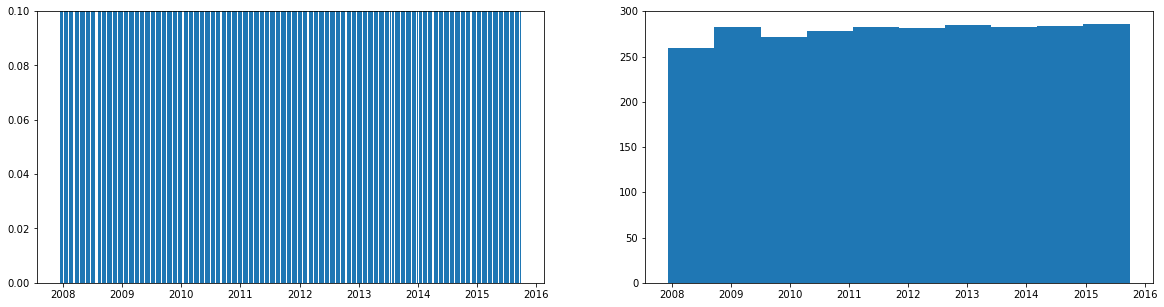

In [ ]:
fig, ax1 = plt.subplots(1, 2, figsize=(20,5))

plt.subplot(1, 2, 1)
plt.ylim(0, 0.1)
bar_1 = plt.bar(clear_data_datetime_1.index, width=0.8, height=0.4)

plt.subplot(1, 2, 2)
hist_1 = plt.hist(clear_data_datetime_1.index);
# ax.set_ylabel('cm')
# ax.set_xticks(x)

<div class='alert class-block alert-info'>
    - На гистограмме хорошо видно, записи до 2009 года неравномерны, но затем визуально становятся равномерны<br>
    - На графике плотности видно, что в разные года количество записей изменяется, а если точнее, то растёт
</div>

## Создание равномерной сезонности

Она нам нужна для нормальной работы моделей регресии

In [ ]:
train_data_count = clear_data_datetime_1['count'].astype(int)
train_data_count

new_date
2015-04-30    1739
2015-04-08    1886
2015-04-09    1838
2015-04-01    1630
2015-04-02    1428
              ... 
2015-08-19    1044
2015-08-18    1005
2015-08-27     899
2015-08-24    1065
2015-08-25    1013
Name: count, Length: 2795, dtype: int32

*Построим график этих данных*

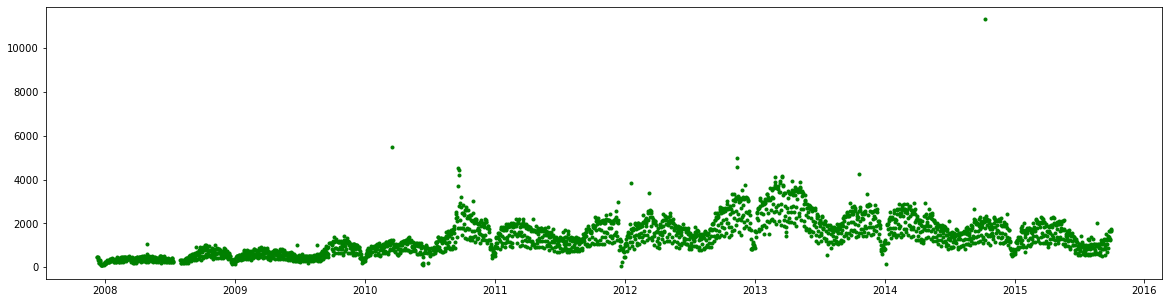

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(train_data_count.index, train_data_count, marker='.', c='green');

*Сделаем частоту данных ежедневной*

In [ ]:
X_recover_dt = pd.date_range(start=train_data_count.index.min(), end=train_data_count.index.max(), freq='D') 
X_recover = np.array(X_recover_dt.astype(int) // 10 ** 9).reshape(-1,1)
X_recover

array([[1197244800],
       [1197331200],
       [1197417600],
       ...,
       [1443398400],
       [1443484800],
       [1443571200]], dtype=int64)

### Восстановим данные с помощью модели регрессии RandomForest

*Переведём даты в POSIX формат для того чтобы модель могла правильно на них обучиться*

Скомпанованный np массив

In [ ]:
train_data_count_1 = np.array(train_data_count.index.astype(int) // 10 ** 9).reshape(-1,1)

temp_var_1 = np.array(train_data_count).reshape(-1,1).astype(int)

train_data_count_1 = np.hstack((train_data_count_1, temp_var_1))

train_data_count_1

array([[1430352000,       1739],
       [1428451200,       1886],
       [1428537600,       1838],
       ...,
       [1440633600,        899],
       [1440374400,       1065],
       [1440460800,       1013]], dtype=int64)

#### Процесс восстановления данных

In [ ]:
from sklearn.ensemble import RandomForestRegressor

*Создадим два NP массива в которые входят все POSIX данные и все данные о посещениях*

In [ ]:
X_all_1 = train_data_count_1[:,0].reshape(-1,1)
y_all_1 = train_data_count_1[:,1].reshape(-1,1)

*Восстановим количество посещений с помощью RF*

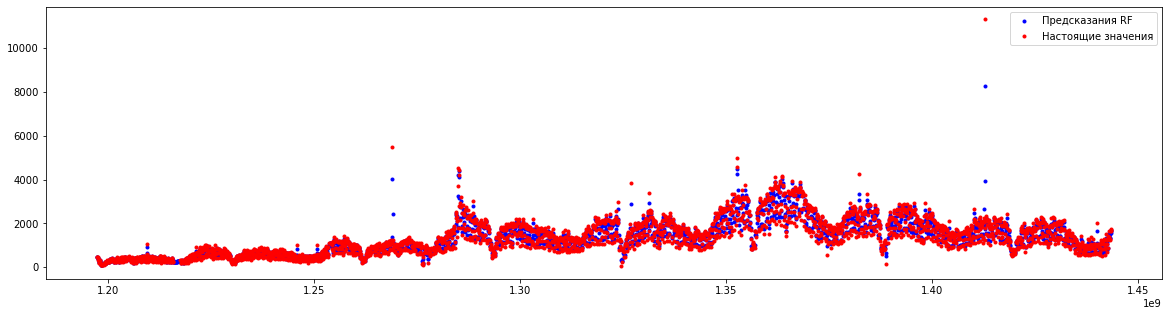

In [ ]:
forest = RandomForestRegressor().fit(X_all_1, y_all_1)
y_recover = forest.predict(X_recover).astype(int)

fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(X_recover, y_recover, color='b', marker='.', label='Предсказания RF')
plt.scatter(X_all_1, y_all_1, color='r', marker='.', label='Настоящие значения')
plt.legend();

<div class='alert class-block alert-info'>
    <code>X_recover</code> и <code>y_recover</code>: ежедневные даты и количество посещений соотв., восстановленные с помощью случайного леса
</div>

*Создадим новые экземпляры данных*
- _pd: Восстановленные данные с индексной PD датой
- _posix: Восстановленные данные с индексной POSIX датой

In [ ]:
recover_all_pd = pd.DataFrame(X_recover_dt, y_recover).reset_index().rename(columns={'index': 'count', 0: 'date'}).set_index('date')
recover_all_posix = pd.DataFrame(X_recover, y_recover).reset_index().rename(columns={'index': 'count', 0: 'date'}).set_index('date')
recover_all_pd

,count
date,
2007-12-10,462
2007-12-11,452
2007-12-12,432
2007-12-13,432
2007-12-14,369
...,...
2015-09-26,1343
2015-09-27,1317
2015-09-28,1582


In [ ]:
recover_all_posix

,count
date,
1197244800,462
1197331200,452
1197417600,432
1197504000,432
1197590400,369
...,...
1443225600,1343
1443312000,1317
1443398400,1582


In [ ]:
recover_all_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2852 entries, 2007-12-10 to 2015-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   2852 non-null   int64
dtypes: int64(1)
memory usage: 44.6 KB


#### Создадим обучающую и тестовую выборки

In [ ]:
X_train_1, y_train_1, X_test_1, y_test_1 = train_test_split_dt(recover_all_pd, recover_all_pd, '2015-01-01')

numpy_info(X_train_1)
numpy_info(y_train_1)

numpy_info(X_test_1)
numpy_info(y_test_1)

class:  ndarray
shape:  (2579, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x206c72c54c0
byteorder:  little
byteswap:  False
type: int64
None 
--------
 [[1197244800]
 [1197331200]
 [1197417600]
 [1197504000]
 [1197590400]] 
--------

class:  ndarray
shape:  (2579, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x206c6d9aac0
byteorder:  little
byteswap:  False
type: int64
None 
--------
 [[462]
 [452]
 [432]
 [432]
 [369]] 
--------

class:  ndarray
shape:  (272, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x206c8c0a380
byteorder:  little
byteswap:  False
type: int64
None 
--------
 [[1420156800]
 [1420243200]
 [1420329600]
 [1420416000]
 [1420502400]] 
--------

class:  ndarray
shape:  (272, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x206c4159210
byteorder:  little
byteswap:  False
typ

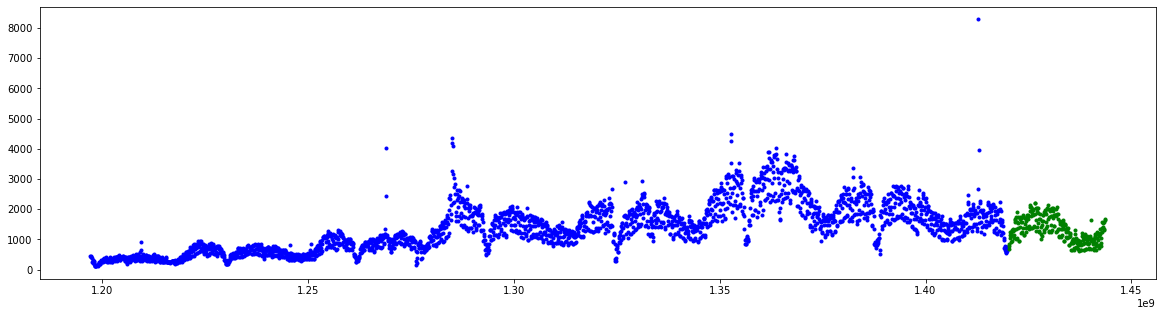

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(X_train_1, y_train_1, marker='.', c='blue', label='Обучающая выборка')
plt.scatter(X_test_1, y_test_1, marker='.', c='green', label='Тестовая');

<div class='alert class-block alert-info'>
    - Была создана обучающая выборка до 2015 год(невключ)<br>
    - Была создана тестовая выборка с 2015 года(включ)
</div>

RandomForestRegressor() -2.234687475393298
ElasticNet() -7.8150810121802134
GradientBoostingRegressor() -1.8013266463145925
SVR() 0.039265146600385714
LinearRegression() -7.8150810123874415


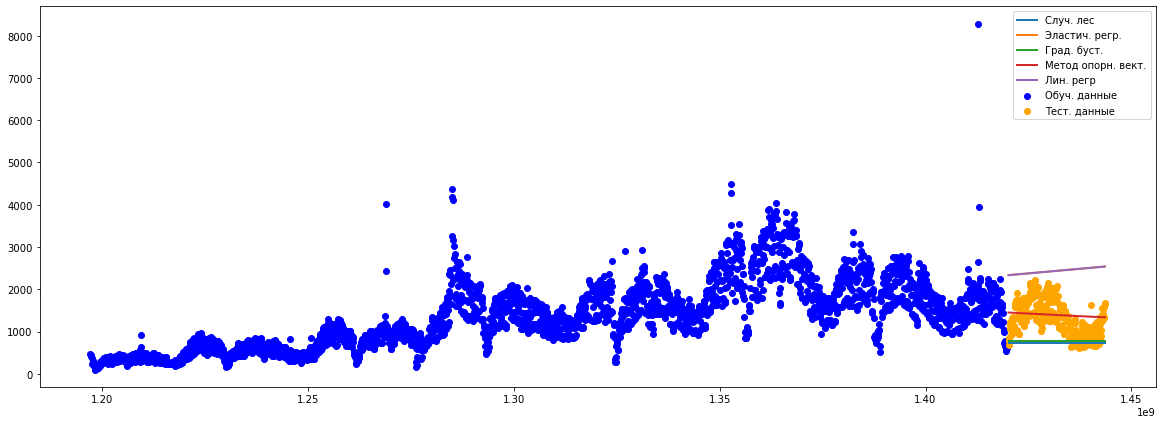

In [ ]:
few_regressors(X_train_1, y_train_1, X_test_1, y_test_1)

# Этап прогноза данных

## Работа с трендом

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

,Seasonality,Trend,Residual,Actual_values
date,,,,
2007-12-10,59.501064,NaN,NaN,462.0
2007-12-11,213.946525,NaN,NaN,452.0
2007-12-12,216.247370,NaN,NaN,432.0
2007-12-13,167.276418,373.285714,-108.562132,432.0
2007-12-14,-41.485253,346.000000,64.485253,369.0


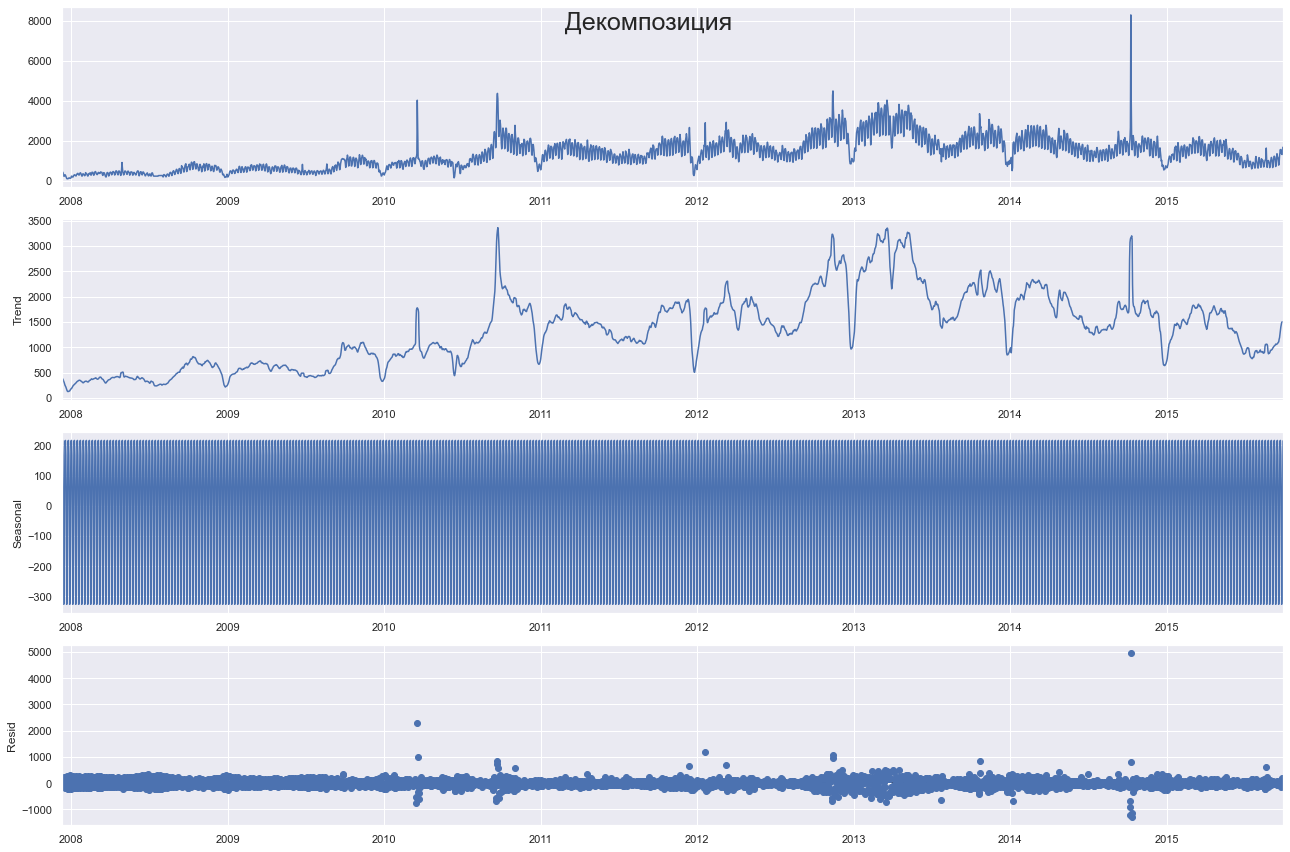

In [ ]:
result_add = seasonal_decompose(recover_all_pd, model='additive') # Декомпозиция

sns.set(rc={'figure.figsize':(18, 12)})
sns.set_style("darkgrid")
result_add.plot().suptitle('Декомпозиция', fontsize=25)

# Выделим Сезонность, Тренд, Остаток после удаления тренда
# Actual Values = Addition of (Seasonality + Trend + Residual)

df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['Seasonality', 'Trend', 'Residual', 'Actual_values']

# Скопируем случайные остатки в другую переменную
ResTime = df_reconstructed[['Residual']]

df_reconstructed.head()

## Выбор метода избавления от тренда

От тренда можно избавиться несколькими путями, например:
- Вычесть из актуальных значений найденный тренд
- Вычитание из одного элемента другого
- Построить ряд на отстаках


### Проверяем на тренд

In [ ]:
from statsmodels.tsa.stattools import adfuller as adf

In [ ]:
adf_test_1 = adf(df_reconstructed.index)
if adf_test_1[1] > 0.05:
    print('Тренд есть')
else:
    print('Тренда нет')

Тренд есть


<div class='alert class-block alert-warning'>
    В данных есть тренд
</div>

### Вычитание тренда

In [ ]:
recover_data_notrend = recover_all_pd
recover_data_notrend['notrend'] = df_reconstructed['Actual_values'] - df_reconstructed['Trend']
recover_data_notrend = recover_data_notrend.dropna().drop('count', axis=1)

count    2846.000000
mean       -0.099237
std       285.126344
min     -1583.285714
25%      -143.857143
50%        32.142857
75%       160.678571
max      5119.428571
Name: notrend, dtype: float64

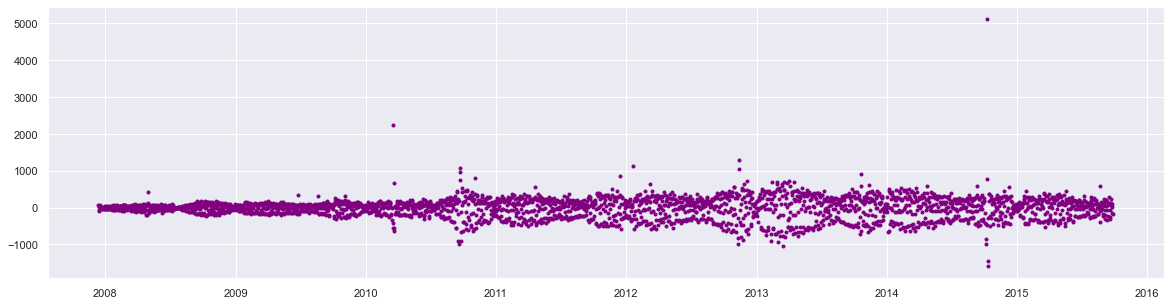

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(recover_data_notrend.index, recover_data_notrend['notrend'], marker='.', c='purple');
recover_data_notrend['notrend'].describe()

### Разность

In [ ]:
recover_data_diff = df_reconstructed['Actual_values'].diff().dropna()
recover_data_diff

date
2007-12-11    -10.0
2007-12-12    -20.0
2007-12-13      0.0
2007-12-14    -63.0
2007-12-15   -131.0
              ...  
2015-09-26   -189.0
2015-09-27    -26.0
2015-09-28    265.0
2015-09-29    101.0
2015-09-30    -39.0
Name: Actual_values, Length: 2851, dtype: float64

count    2851.000000
mean        0.414591
std       294.967468
min     -4331.000000
25%      -127.000000
50%        -1.000000
75%       112.000000
max      5629.000000
Name: Actual_values, dtype: float64

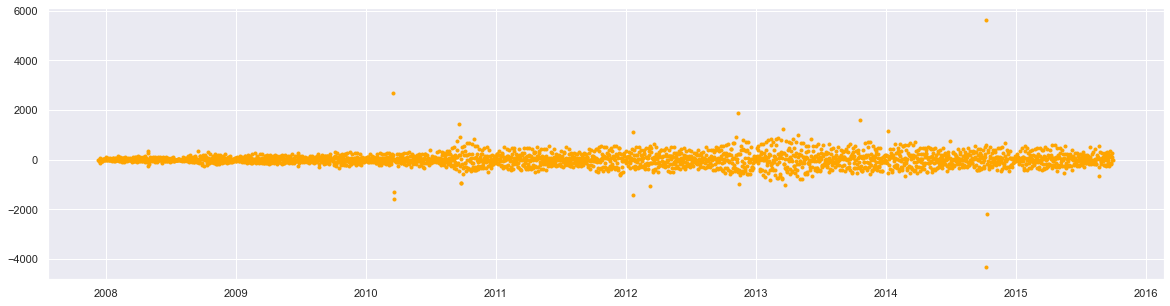

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(recover_data_diff.index, recover_data_diff, marker='.', c='orange');
recover_data_diff.describe()

### Остатки

In [ ]:
recover_data_resid = recover_all_pd
recover_data_resid = df_reconstructed['Residual'].dropna()
recover_data_resid

date
2007-12-13   -108.562132
2007-12-14     64.485253
2007-12-15    239.218492
2007-12-16    212.839061
2007-12-17    -64.358207
                 ...    
2015-09-23     10.609773
2015-09-24   -158.847847
2015-09-25    125.056681
2015-09-26    179.361350
2015-09-27    104.410490
Name: Residual, Length: 2846, dtype: float64

count    2846.000000
mean        0.072827
std       190.100168
min     -1294.446653
25%       -94.487462
50%        -6.685509
75%        83.066313
max      4952.152153
Name: Residual, dtype: float64

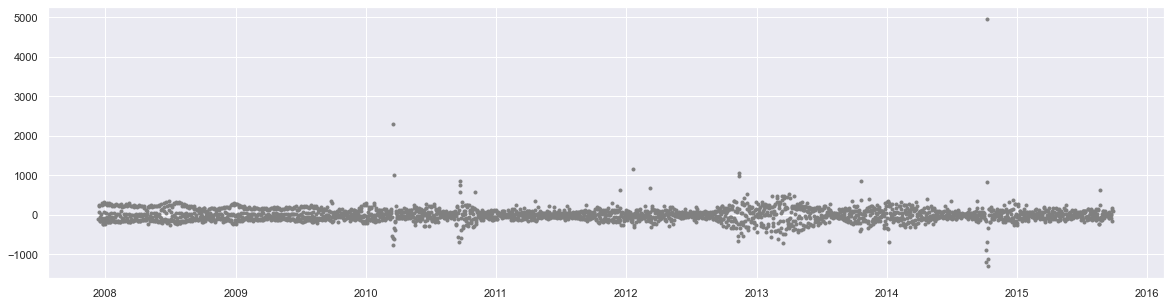

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
plt.scatter(recover_data_resid.index, recover_data_resid, marker='.', c='grey');
recover_data_resid.describe()

## Проверим точность работы моделей на каждых данных

Для этого воспользуемся несколькими моделями:
- Случайным лесом
- Линейной регрессией
- Градиентным бустингом
- Эластичной регрессией
- Метод опорных векторов

In [ ]:
# Модели для регуляризации
models = []

models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet())) # kernel = linear
models.append(('GB', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

### Данные с вычтенным трендом

LinearRegression() 
RMSE: 225.82229757905867
Mean: -5.18560853519201e-05 
Std: 6.811237437112008e-05 

ElasticNet() 
RMSE: 225.82224734424878
Mean: -5.185607949544924e-05 
Std: 6.811236492581675e-05 

GradientBoostingRegressor() 
RMSE: 225.8296625388921
Mean: -0.29583925320186644 
Std: 0.16962374770424304 

RandomForestRegressor(n_estimators=10) 
RMSE: 228.21804363959185
Mean: -0.25260035158242367 
Std: 0.23459823360900683 

SVR(gamma='auto') 
RMSE: 227.9656654667222
Mean: -0.0040066284741556045 
Std: 0.0018907455304218311 



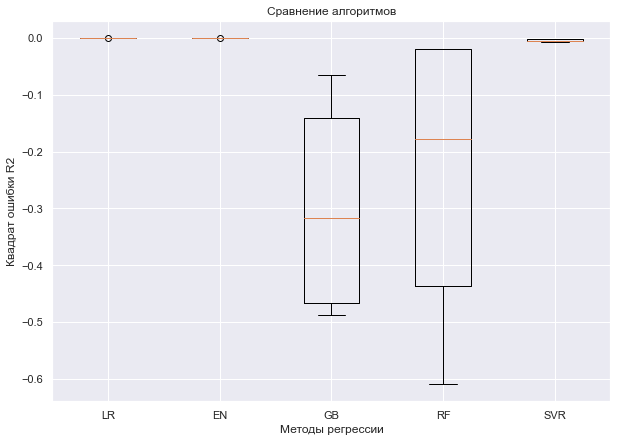

RandomForestRegressor() -0.012043504065867294
ElasticNet() -1.2321830953121449e-05
GradientBoostingRegressor() -7.755162288591855e-05
SVR() -0.03283460497649271
LinearRegression() -1.2321831462047683e-05


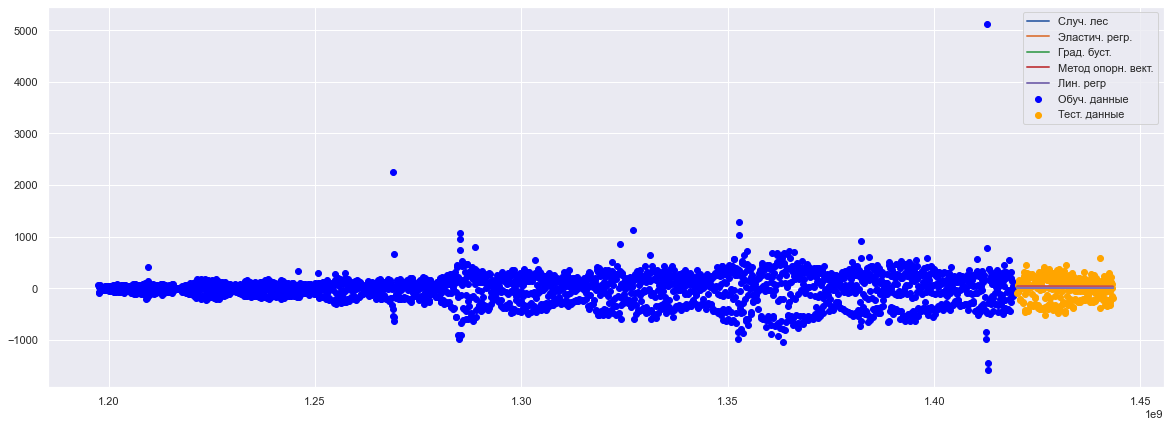

In [ ]:
X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend = train_test_split_dt(recover_data_notrend, recover_data_notrend, '2015-01-01')

names, results, results_rmse = cross_val(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend, models)

few_regressors(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend)

### Данные с разностью

LinearRegression() 
RMSE: 221.53571629437235
Mean: -7.039232793113471e-05 
Std: 5.154435972005803e-05 

ElasticNet() 
RMSE: 221.53680774372322
Mean: -7.03923273939644e-05 
Std: 5.154435634764061e-05 

GradientBoostingRegressor() 
RMSE: 223.68996532773684
Mean: -0.2157346510166213 
Std: 0.20889498208737156 

RandomForestRegressor(n_estimators=10) 
RMSE: 221.46755770913052
Mean: -0.11566155051659095 
Std: 0.12321189272082658 

SVR(gamma='auto') 
RMSE: 221.51637898565278
Mean: -0.00011249037799343498 
Std: 0.00014041961008711253 



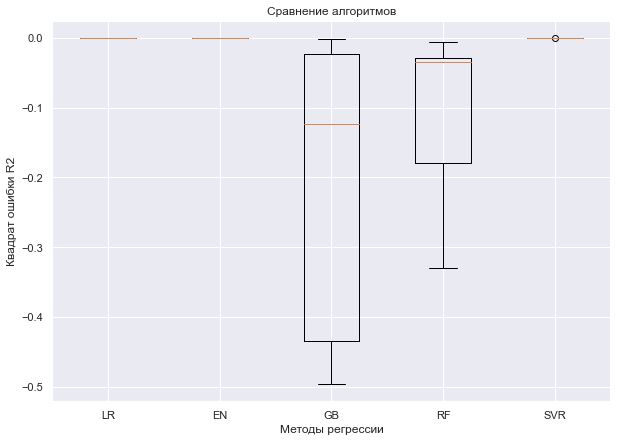

RandomForestRegressor() -0.00012685764144637623
ElasticNet() -0.0006169327211162923
GradientBoostingRegressor() -0.02017187122976849
SVR() -0.001930273324727505
LinearRegression() -0.0006169327244140987


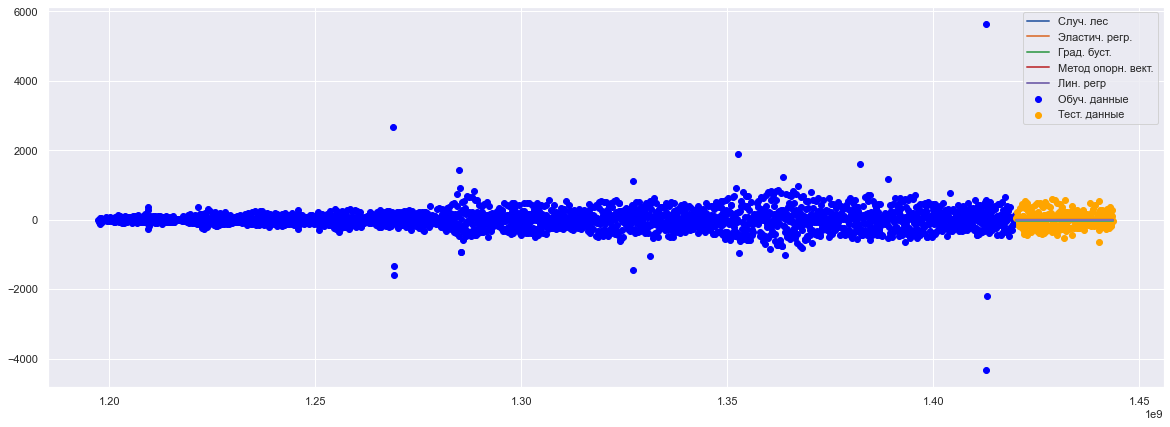

In [ ]:
X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend = train_test_split_dt(recover_data_diff, recover_data_diff, '2015-01-01')

names, results, results_rmse = cross_val(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend, models)

few_regressors(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend)

### Данные с остатками

LinearRegression() 
RMSE: 97.65780855604149
Mean: -2.54769507997743e-05 
Std: 4.380654556530087e-05 

ElasticNet() 
RMSE: 97.65803235166992
Mean: -2.5476946380686984e-05 
Std: 4.380653842925725e-05 

GradientBoostingRegressor() 
RMSE: 196.92361385339757
Mean: -0.1722858762017645 
Std: 0.21852610260772443 

RandomForestRegressor(n_estimators=10) 
RMSE: 184.87333194531806
Mean: -0.11067960099014354 
Std: 0.15228827516602933 

SVR(gamma='auto') 
RMSE: 98.05370107655307
Mean: -0.022128874838038114 
Std: 0.019434584198442243 



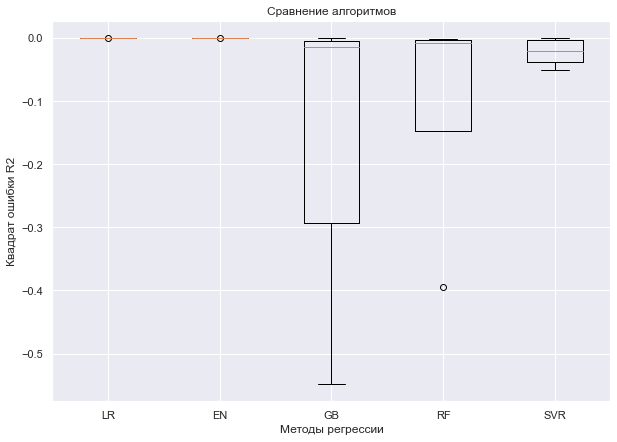

RandomForestRegressor() -2.5368258567198723
ElasticNet() -0.000435399657836788
GradientBoostingRegressor() -3.0679040053613145
SVR() -0.016237095023629466
LinearRegression() -0.00043539966397876384


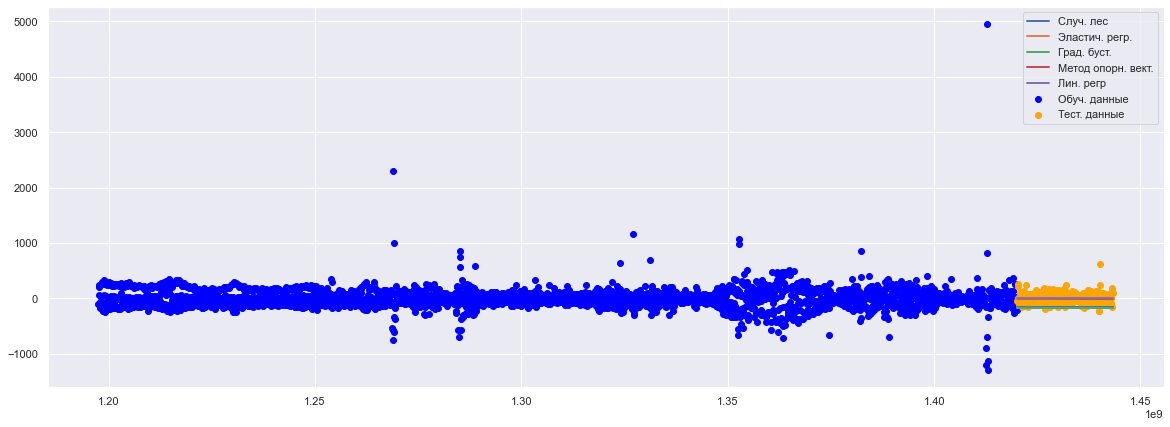

In [ ]:
X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend = train_test_split_dt(recover_data_resid, recover_data_resid, '2015-01-01')

names, results, results_rmse = cross_val(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend, models)

few_regressors(X_train_notrend, y_train_notrend, X_test_notrend, y_test_notrend)